### **Step 0 - Loading the Packages**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pandas as pd
from tabulate import tabulate


### **Step  1 - Loading the dataset and printing  basic information about the data**

In [ ]:
#from google.colab import files
#files.upload()

file_path = '/content/phishing_site_urls.csv'

In [ ]:
file = 'phishing_site_urls.csv'

#Load the dataset
data_frame= pd.read_csv(file_path)
print(data_frame.head)
print(data_frame.shape)

<bound method NDFrame.head of                                                       URL Label
0       nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1       www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2       serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3       mail.printakid.com/www.online.americanexpress....   bad
4       thewhiskeydregs.com/wp-content/themes/widescre...   bad
...                                                   ...   ...
549341                                    23.227.196.215/   bad
549342                                 apple-checker.org/   bad
549343                                  apple-iclods.org/   bad
549344                                 apple-uptoday.org/   bad
549345                                  apple-search.info   bad

[549346 rows x 2 columns]>
(549346, 2)


### **Step 2 - Data Preprocessing**

In [ ]:
# Preprocess the data:
# Convert URLs to lowercase
data_frame ['URL'] = data_frame['URL'].apply(lambda x: x.lower ())

# remove duplicates
data_frame.drop(data_frame[data_frame.URL.duplicated() == True].index, axis=0, inplace=True)
data_frame .reset_index(drop=True)

# replace text labels with integer labels:
data_frame[ 'Label'] = data_frame[ 'Label']. replace({'bad': 0, 'good': 1})

# You can see that the number of rows is reduced since we removed duplicates:
print(data_frame.shape) # print dataset size: (# of rows, # of columns)

(507111, 2)


### **Step 3 - Convert a URL into a sequence of integers and pad the sequence to make it the same length:**

In [ ]:
# Machine learning is to find the function f such that f(X) --> y
# Get X and y from the dataframe:
X = data_frame['URL'].values
y = data_frame['Label'].values  # 'label' is the column with phishing labels

# The original dataset is too big: 507K rows. I choose 50% of it for this assignment:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Tokenize: convert characters into integers:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# Pad the the sequence to make sure each input data has the same length:
#max_len = max([len(seq) for seq in sequences])  <-- this line causes the RAM issue,
# because max_len is more than 1K from the dataset.
max_len = 200 # <--instead, use a much smaller length
X_padded = pad_sequences(sequences, maxlen=max_len, padding='post')
# "post" means: the padding, zeros, should be added at the end if a sequence is shorter than max_len

In [ ]:
print(X[1])
print(X_padded [1])
print(y[:4])
print(len(X_padded [1]))

jorgensenconveyors.com/replacement.aspx
[39  2  9 20  1 10  8  1 10  7  2 10 29  1 25  2  9  8 12  7  2 11  5  9
  1 15 13  3  7  1 11  1 10  6 12  3  8 15 37  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
[0 1 1 1]
200


### **Step 4 - Split dataset, convert data into PyTorch tensors, and then create DataLoader instances**



In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.5, random_state=42)

# If you need to reduce the dataset, keep splitting the data into training and testing sets:
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3,random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define the dataset class
class PhishingDataset(Dataset):
    def __init__(self, X, y):
      self.X = X
      self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader instances
train_dataset = PhishingDataset(X_train_tensor, y_train_tensor)
test_dataset = PhishingDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # 32 samples will be loaded and passed to the model in each iteration of the training loop
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # 32 samples will be loaded and passed to the model in each iteration of the testing loop

### **Step 5 - Define our LSTM model**

In [ ]:
# Define the LSTM model
class PhishingClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(PhishingClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # embedding layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True) # LSTM layer
        self.fc = nn.Linear(hidden_dim, output_dim)  # fully connected layer
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #embedding: convert words/tokens into a more meaningful dense vector of fixed size
        embedded = self.embedding(x)  # send x to the embedding layer
        _, (hidden, _) = self.lstm(embedded) # to the LSTM layer
        out = self.fc(hidden[-1])#only pass the last hidden state of LSTM to the fc layer
        return self.sigmoid(out) # sigmoid: the probability that input x is phishing

### **Step 6 - Instantiate our LSTM model and train the model**

In [ ]:
# Instantiate the model
vocab_size = len(tokenizer.word_index) + 1
# embedding: a dense vector of size 32
# the LSTM's hidden state's dimension is 64
# the fully connected layer's dimension is 1
model = PhishingClassifier(vocab_size, embedding_dim=32, hidden_dim=64, output_dim=1)
# Define loss function and optimizer
criterion = nn.BCELoss() #  the Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store training loss and accuracy
train_loss_history = []
train_accuracy_history = []

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.squeeze(), target)
        loss.backward()
        optimizer.step()

    # Calculate accuracy during training
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0

        for data, target in train_loader:  # Use train_loader for training accuracy
            output = model(data)
            predicted = (output.squeeze() > 0.5).float()
            total += target.size(0)
            correct += (predicted == target).sum().item()

    train_accuracy = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Training Accuracy: {train_accuracy}')

    # Append loss and accuracy to the history lists
    train_loss_history.append(loss.item())
    train_accuracy_history.append(train_accuracy)

Epoch 1/10, Loss: 0.2353014051914215, Training Accuracy: 0.8949493993389969
Epoch 2/10, Loss: 0.057954415678977966, Training Accuracy: 0.9408962193457804
Epoch 3/10, Loss: 0.2591412365436554, Training Accuracy: 0.9582416368899721
Epoch 4/10, Loss: 0.09283746033906937, Training Accuracy: 0.9653880435725724
Epoch 5/10, Loss: 0.016597045585513115, Training Accuracy: 0.9712487280815921
Epoch 6/10, Loss: 0.0193292498588562, Training Accuracy: 0.9715011397966508
Epoch 7/10, Loss: 0.03154568001627922, Training Accuracy: 0.9750270159413774
Epoch 8/10, Loss: 0.02233760617673397, Training Accuracy: 0.9760287749355167
Epoch 9/10, Loss: 0.00425653625279665, Training Accuracy: 0.9779060870662659
Epoch 10/10, Loss: 0.0765443965792656, Training Accuracy: 0.9848237456320942


### **Step 7 - Evaluate the Model**

In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad() :
  correct = 0
  total = 0

  for data, target in test_loader:
    output = model(data)
    predicted = (output.squeeze() > 0.5).float()
    total += target.size(0)
    correct += (predicted == target).sum().item()
  print(f'Accuracy: {correct / total}')

Accuracy: 0.9707993500449604


### **Plotting the Graphs**

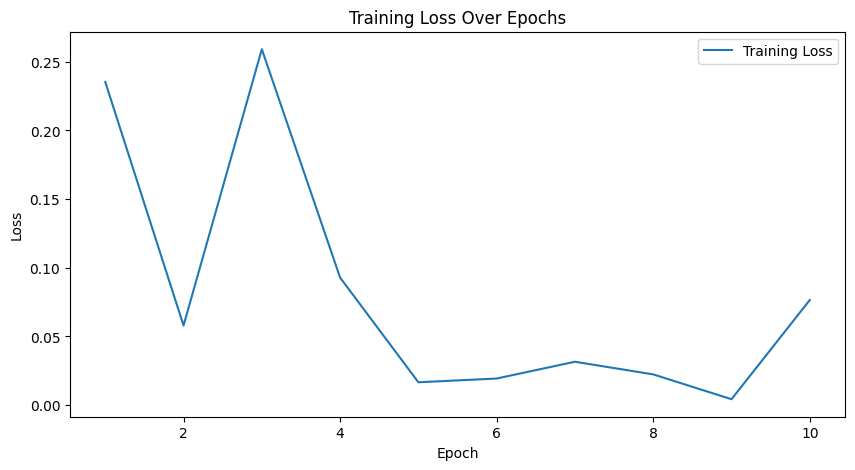

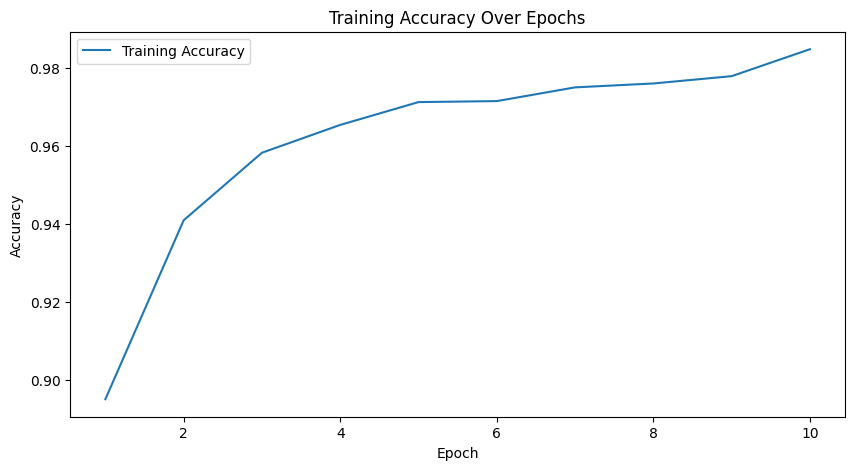

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracy_history, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()